## CITS2402 - Introduction to Data Science - Assignment.

### Comparing Demographic Trends in Australian and New Zealand Census Data

**Date:** August 2024.

## Declaration

This declaration should be completed and remain attached to the top of your submission.

*I/we am/are aware of the University’s [policy on academic conduct](https://www.uwa.edu.au/policy/-/media/Project/UWA/UWA/Policy-Library/Policy/Student-Administration/Academic-Integrity/Academic-Integrity-Policy.doc) and I declare that this assignment is entirely the work of the author(s) listed below and that suitable acknowledgement has been made for any sources of information used in preparing it. I have retained a copy for my own records.*

- Name 1:
- Student ID 1:
- Name 2: 
- Student ID 2:
- Name 3:
- Student ID 3:
- Date:


The suffix `-template` should be replaced with the corresponding student numbers. For instance, if you are doing your assignment with another person, you should rename your file as `CITS2402-Assignment-STDNO1-STDNO2.ipynb`, where 'STDNO1' and 'STDNO2' are the corresponding student numbers involved in the submission. 

<hr>


In [1]:
# Install the necessary packages
from IPython.display import clear_output

%pip install numpy
%pip install pandas
%pip install matplotlib

clear_output()

Importing the libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ds_path = "./datasets"

Defining helper functions

In [3]:
from enum import Enum
from types import DynamicClassAttribute

# overcomplicated but fun way to abstract
class Type(Enum):
    MALE = "Male",
    FEMALE = "Female",
    TOTAL = "Total",

    def __str__(self) -> str:
        return self.value[0]
    
    @DynamicClassAttribute
    def aus_prefix(self) -> str:
        match self:
            case Type.MALE | Type.FEMALE: return f"{self.value[0][0]}_"
            case Type.TOTAL: return "P_"

    @DynamicClassAttribute
    def us_prefix(self) -> str:
        return self.value[0]

Defining the cleaning function for Australia

In [4]:
# cleaning function for the AUS dataset
def load_data_aus(filenames: list[str]) -> pd.DataFrame:
    df = pd.concat([pd.read_csv(f"{ds_path}/{filename}") for filename in filenames], axis=1)
    metadata = pd.read_excel(f"{ds_path}/AUS/metadata.xlsx", sheet_name="Cell Descriptors Information", skiprows=10)

    # find all columns that end with _Tot for certain type
    def get_total_for(type: Type) -> pd.DataFrame:
        total_colums = [col for col in df.columns if col.startswith(type.aus_prefix) and col.endswith("_Tot")]
        tdf = df[total_colums]

        # find the long name of the columns, strip the prefix and postfix and replace _ with spaces
        def get_long_name(col: str) -> str:
            long_name = metadata[metadata["Short"] == col]["Long"].iat[0]
            long_name = long_name[long_name.index("_")+1:]  # strip the prefix
            long_name = long_name[:-6]                      # strip the postfix
            long_name = long_name.replace('_', ' ')         # replace _ with space
            return long_name

        tdf.columns = [get_long_name(col) for col in total_colums]
        tdf.insert(0, "Type", type)
        return tdf
    
    male_df = get_total_for(Type.MALE)
    female_df = get_total_for(Type.FEMALE)
    person_df = get_total_for(Type.TOTAL)

    tdf = pd.concat([male_df, female_df, person_df])
    tdf.set_index("Type", inplace=True)
    return tdf

Defining the cleaning function for the US

In [5]:
def load_data_us(filename: str, subcat: int = 0) -> pd.DataFrame:
    df = pd.read_csv(f"{ds_path}/{filename}", skiprows=1)

    def find_estimates_for(type: Type) -> pd.DataFrame:
        estimate_columns = [col for col in df.columns if 
                            type.us_prefix in col 
                            and "Estimate" in col
                            and "Percent" not in col # exclude percentage columns in the us 2016 dataset
                            and (col.count("!!") == subcat + 2 if subcat > 0 else True)] # subcategories for the 2023 dataset

        if subcat > 0: # if we have subcategories, then it's the 2023 dataset, add the total column anyway (a hack)
            estimate_columns += ["Estimate!!Total!!Civilian employed population 16 years and over"]

        edf = df[estimate_columns].copy()

        edf.columns = [col[col.rfind("!!")+2:].strip(':') for col in estimate_columns]
        edf["Total"] = edf.pop("Civilian employed population 16 years and over") # move total to the end

        edf.insert(0, "Type", type)
        return edf

    male_df = find_estimates_for(Type.MALE)
    female_df = find_estimates_for(Type.FEMALE)
    total_df = find_estimates_for(Type.TOTAL)

    edf = pd.concat([male_df, female_df, total_df])
    edf.set_index("Type", inplace=True)
    return edf

Loading the data for Australia, year 2016

In [6]:
# 2016 Census Australia
aus2016 = load_data_aus(
    [
        "/AUS/2016/2016Census_G51A_AUS.csv",
        "/AUS/2016/2016Census_G51B_AUS.csv",
        "/AUS/2016/2016Census_G51C_AUS.csv",
        "/AUS/2016/2016Census_G51D_AUS.csv"
    ]
)
aus2016

,Agriculture Forestry and Fishing,Mining,Manufacturing,Electricity Gas Water and Waste Services,Construction,Wholesale Trade,Retail Trade,Accommodation and Food Services,Transport Postal and Warehousing,Information Media and Telecommunications,...,Rental Hiring and Real Estate Services,Professional Scientific and Technical Services,Administrative and Support Services,Public Administration and Safety,Education and Training,Health Care and Social Assistance,Arts and Recreation Services,Other Services,Inadequately described Not stated,Total
Type,,,,,,,,,,,,,,,,,,,,,
Male,185212,149060,493124,88111,793044,202328,453244,335872,382265,108320,...,88667,426413,173313,380773,266099,289962,92663,215410,297400,5607777
Female,81739,28581,190564,27642,118009,105414,600569,402363,117228,71203,...,93482,349560,192420,332366,659792,1061051,84002,184225,177746,5076066
Total,266946,177647,683688,115753,911056,307741,1053816,738231,499491,179521,...,182151,775978,365731,713135,925895,1351015,176667,399635,475143,10683842


Loading the data for Australia, year 2021

In [7]:
# 2021 Census Australia
aus2021 = load_data_aus(
    [
        "/AUS/2021/2021Census_G54A_AUS_AUS.csv",
        "/AUS/2021/2021Census_G54B_AUS_AUS.csv",
        "/AUS/2021/2021Census_G54C_AUS_AUS.csv",
        "/AUS/2021/2021Census_G54D_AUS_AUS.csv"
    ]
)
aus2021

,Agriculture Forestry and Fishing,Mining,Manufacturing,Electricity Gas Water and Waste Services,Construction,Wholesale Trade,Retail Trade,Accommodation and Food Services,Transport Postal and Warehousing,Information Media and Telecommunications,...,Rental Hiring and Real Estate Services,Professional Scientific and Technical Services,Administrative and Support Services,Public Administration and Safety,Education and Training,Health Care and Social Assistance,Arts and Recreation Services,Other Services,Inadequately described Not stated,Total
Type,,,,,,,,,,,,,,,,,,,,,
Male,191574,174695,503739,99798,910676,204844,481042,358848,417438,100578,...,91528,515326,187252,419100,290405,390529,94655,227859,320475,6200207
Female,90651,40064,211021,34567,156968,107022,618571,424891,128926,66291,...,96089,429767,201179,377933,770920,1361188,93826,207598,206455,5849207
Total,282227,214759,714759,134368,1067645,311863,1099617,783737,546364,166872,...,187621,945094,388432,797031,1061320,1751717,188479,435459,526932,12049410


Loading the data for the US, year 2016

In [8]:
us2016 = load_data_us("/US/2016/ACSST1Y2016.S2403-Data.csv")
us2016

,"Agriculture, forestry, fishing and hunting, and mining","Agriculture, forestry, fishing and hunting","Mining, quarrying, and oil and gas extraction",Construction,Manufacturing,Wholesale trade,Retail trade,"Transportation and warehousing, and utilities",Transportation and warehousing,Utilities,...,Administrative and support and waste management services,"Educational services, and health care and social assistance",Educational services,Health care and social assistance,"Arts, entertainment, and recreation, and accommodation and food services","Arts, entertainment, and recreation",Accommodation and food services,"Other services, except public administration",Public administration,Total
Type,,,,,,,,,,,,,,,,,,,,,
Male,2122600,1518934,603666,8889846,10950133,2818088,8907301,6032144,5070851,961293,...,3955538,9038723,4429308,4609415,7352595,1812533,5540062,3481038,3880253,80047885
Female,526807,416428,110379,920282,4472342,1226186,8573598,1918945,1645900,273045,...,2599991,26021878,9489918,16531960,7674792,1545749,6129043,4042462,3114333,72523156
Total,2649407,1935362,714045,9810128,15422475,4044274,17480899,7951089,6716751,1234338,...,6555529,35060601,13919226,21141375,15027387,3358282,11669105,7523500,6994586,152571041


Loading the data for the US, year 2023

In [9]:
us2023 = load_data_us("/US/2023/ACSST1Y2023.S2401-Data.csv", subcat=2) # second level subcategories
us2023

,"Management, business, and financial occupations","Computer, engineering, and science occupations","Education, legal, community service, arts, and media occupations",Healthcare practitioners and technical occupations,Healthcare support occupations,Protective service occupations,Food preparation and serving related occupations,Building and grounds cleaning and maintenance occupations,Personal care and service occupations,Sales and related occupations,Office and administrative support occupations,"Farming, fishing, and forestry occupations",Construction and extraction occupations,"Installation, maintenance, and repair occupations",Production occupations,Transportation occupations,Material moving occupations,Total
Type,,,,,,,,,,,,,,,,,,
Male,15677653,8850421,6346915,2604284,852508,2631756,3861235,3234131,1072060,7458994,4480985,677066,7625769,4798131,6123844,5207016,4578048,164346993
Female,13859225,3260431,12359786,7960923,4544337,807495,4718556,2208019,3053146,7170110,12315361,243107,311908,193520,2540046,940099,1780108,164346993
Total,29536878,12110852,18706701,10565207,5396845,3439251,8579791,5442150,4125206,14629104,16796346,920173,7937677,4991651,8663890,6147115,6358156,164346993


#### **Question 1:**
**Have the share of health workers increased for Australia from 2016 to 2021 and for the US from 2016 to 2023?**

Visualizing the data for Australia

In [10]:
def pieplot_health(data: pd.DataFrame, title: str, ax: plt.Axes):
    labels = ["Men in Health", "Women in Health", "Other"]
    colors = ["deepskyblue", "lightcoral", "navajowhite"]

    health_data = data.filter(like="Health")
    health_num_male = health_data.loc[Type.MALE].sum()
    health_num_female = health_data.loc[Type.FEMALE].sum()
    health_num_other = data.loc[Type.TOTAL].drop("Total").drop(health_data).sum()

    health_num_total = health_num_male + health_num_female
    data_num_total = data.loc[Type.TOTAL, "Total"]
    percentage_in_health = health_num_total / data_num_total * 100

    ax.pie(
        [health_num_male, health_num_female, health_num_other],
        labels=labels, colors=colors, autopct='%1.1f%%'
    )
    ax.set_title(title)
    ax.set_xlabel(f"Total percent of people in healthcare: {percentage_in_health:.1f}%")

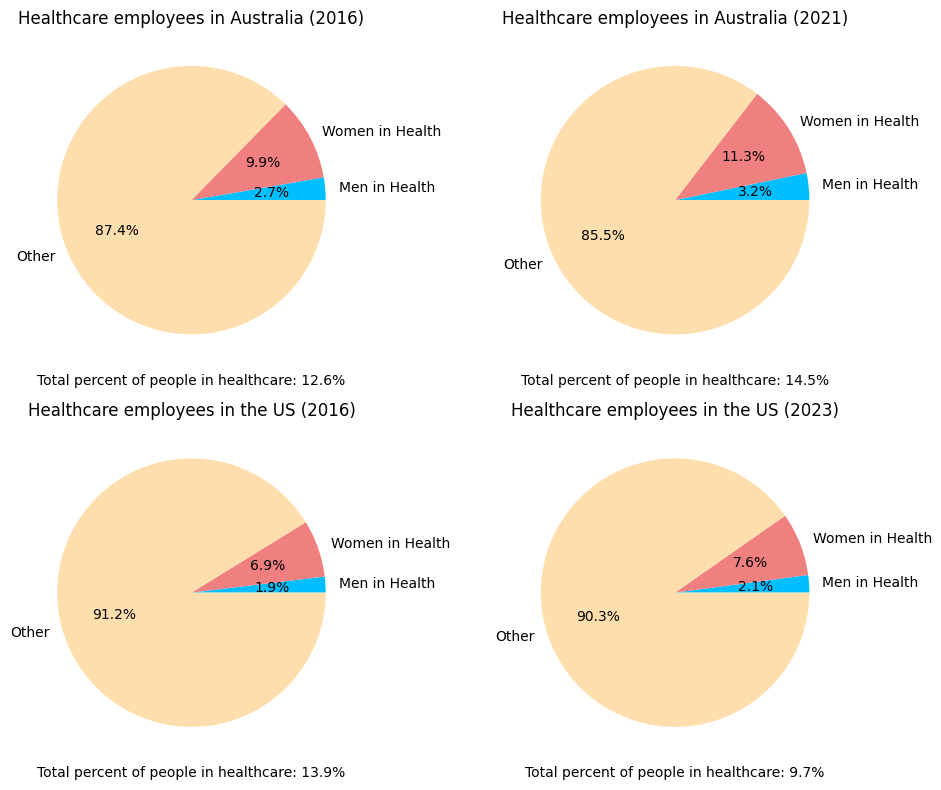

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8)) 
pieplot_health(aus2016, "Healthcare employees in Australia (2016)", ax=axes[0][0])
pieplot_health(aus2021, "Healthcare employees in Australia (2021)", ax=axes[0][1])
pieplot_health(us2016, "Healthcare employees in the US (2016)", ax=axes[1][0])
pieplot_health(us2023, "Healthcare employees in the US (2023)", ax=axes[1][1])
plt.tight_layout()

##### Conclusion:
TODO

#### **Question 2:**
**How the gender proportions have changed over the years?**

*Since we already have the charts we probably just need to write the conclusion here*

#### **Question 3:**
**Is the percentage of health workers more or less than average in Australia and in the US?**

Comparing averages:

In [12]:
def barplot_average(data: pd.DataFrame, title: str, ax: plt.Axes, ylim: float):
    data = data.loc[Type.TOTAL].drop("Total")

    ax.bar(data.index, data.values, color=plt.cm.tab20.colors, label=data.index)
    ax.axhline(data.mean(), color="red", linestyle="--", label=f"Mean: {data.mean():.2f}")
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1.02), fontsize="small", ncol=1)

    ax.set_ylim(0, ylim)
    ax.set_title(title)
    ax.set_xlabel("Industries")
    ax.set_ylabel("Number of people")
    ax.set_xticks([])

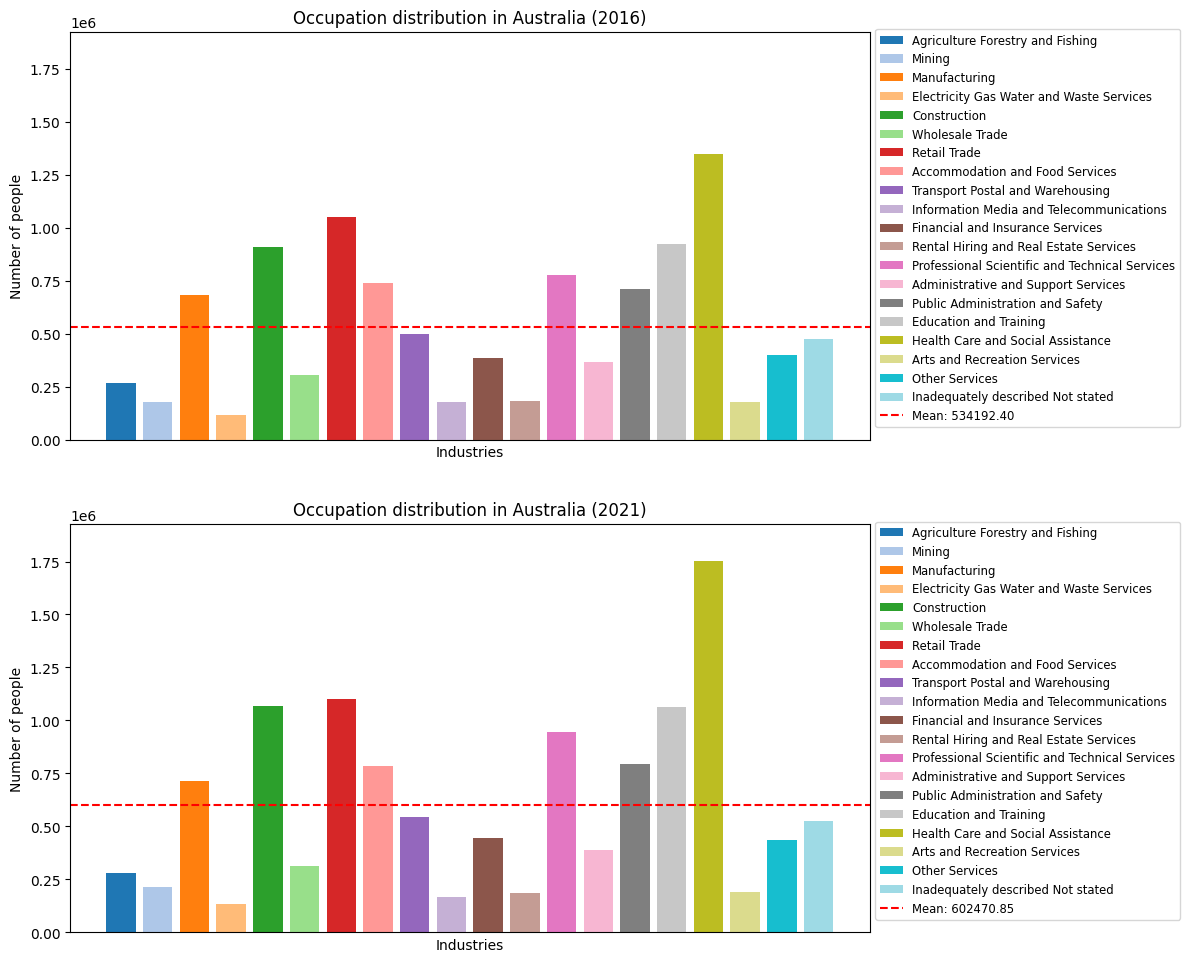

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
max_2016 = aus2016.loc[Type.TOTAL].drop("Total").max()
max_2021 = aus2021.loc[Type.TOTAL].drop("Total").max()
ylim = max(max_2016, max_2021) * 1.1
barplot_average(aus2016, "Occupation distribution in Australia (2016)", ax=axes[0], ylim=ylim)
barplot_average(aus2021, "Occupation distribution in Australia (2021)", ax=axes[1], ylim=ylim)
plt.tight_layout()

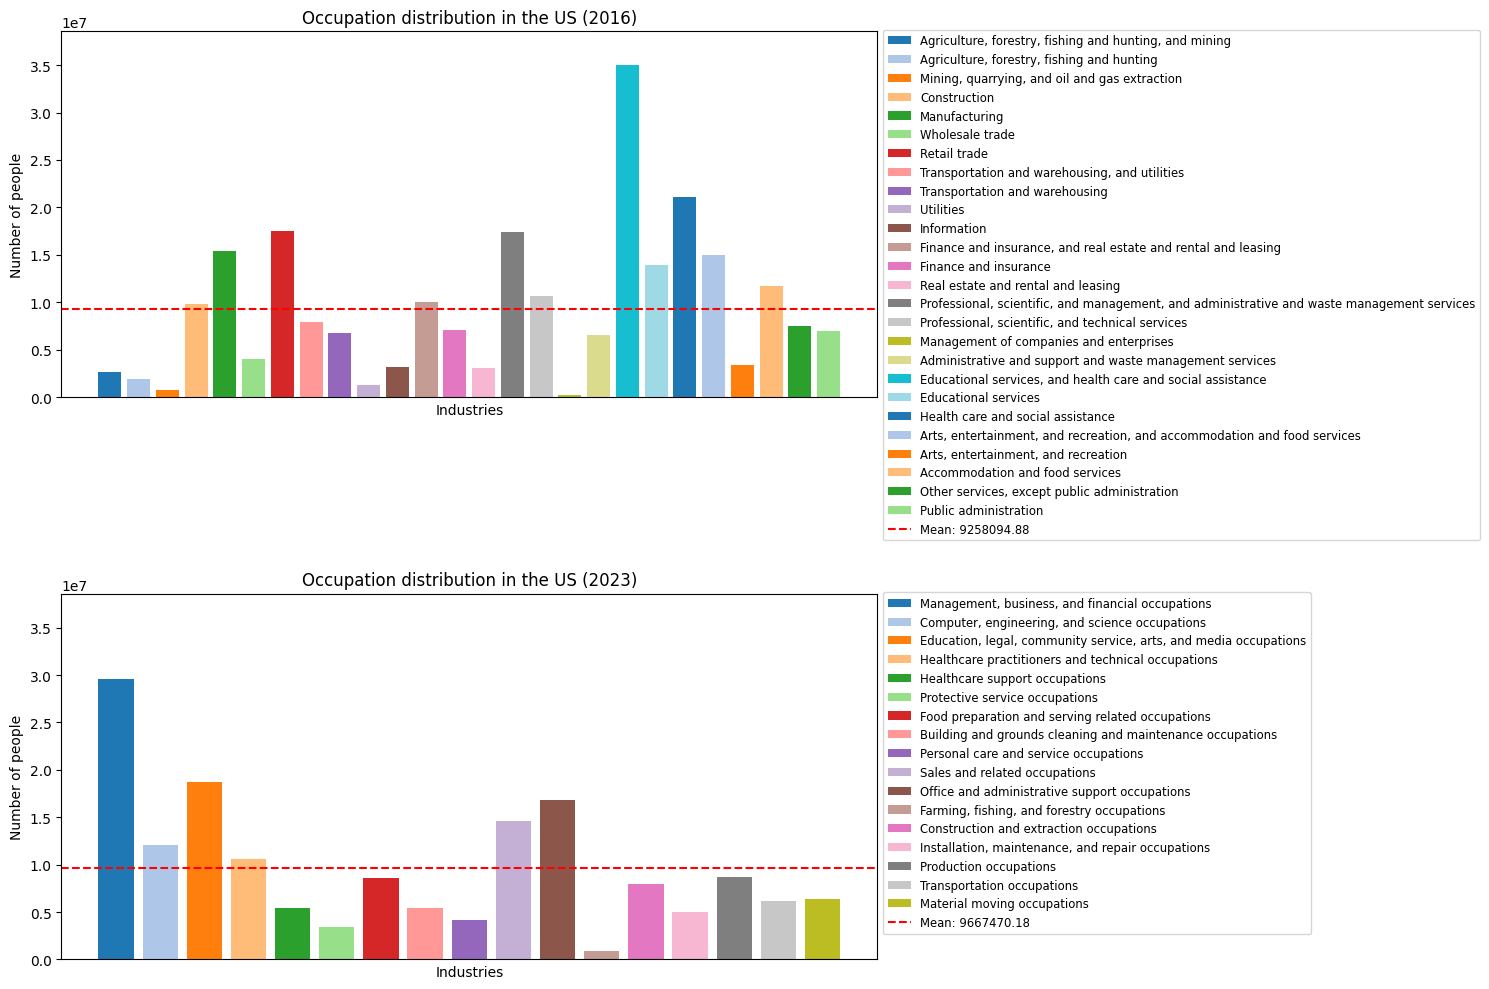

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
max_2016 = us2016.loc[Type.TOTAL].drop("Total").max()
max_2023 = us2023.loc[Type.TOTAL].drop("Total").max()
ylim = max(max_2016, max_2023) * 1.1
barplot_average(us2016, "Occupation distribution in the US (2016)", ax=axes[0], ylim=ylim)
barplot_average(us2023, "Occupation distribution in the US (2023)", ax=axes[1], ylim=ylim)
plt.tight_layout()

Comparing side by side:

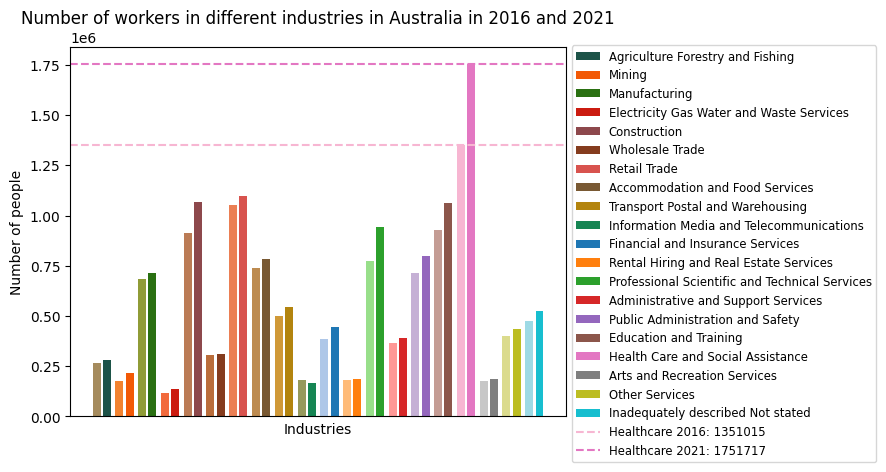

In [15]:
# Comparing Side By Side
def barplot_average_sbs(left: pd.DataFrame, right: pd.DataFrame, title: str, year_left: str, year_right: str):
    index = np.arange(len(left))
    bar_width = 0.35

    color_map = plt.cm.tab20.colors
    color_map_extended = \
        tuple((x[0] * 0.95, x[1] * 0.7, x[2] * 0.4) for x in color_map) \
        + color_map
    color_map_left = color_map_extended[1::2]
    color_map_right = color_map_extended[::2] 

    plt.bar(index, left.values, bar_width, color=color_map_left)
    plt.bar(index + bar_width + 0.1, right.values, bar_width, label=left.index, color=color_map_right)

    health_left = left.filter(like="Health").iat[0]
    health_right = right.filter(like="Health").iat[0]
    plt.axhline(health_left, color=color_map_left[16], linestyle="--", label=f"Healthcare {year_left}: {health_left}")
    plt.axhline(health_right, color=color_map_right[16], linestyle="--", label=f"Healthcare {year_right}: {health_right}")

    plt.legend(loc="upper left", bbox_to_anchor=(1, 1.02), fontsize="small", ncol=1)

    plt.xlabel('Industries')
    plt.ylabel('Number of people')
    plt.title(title)

    plt.xticks([])

left = aus2016.loc[Type.TOTAL].drop("Total")
right = aus2021.loc[Type.TOTAL].drop("Total")
barplot_average_sbs(
    left, right,
    title='Number of workers in different industries in Australia in 2016 and 2021',
    year_left="2016", year_right="2021"
)

**Interpretation:** 
This plot combines data of Australia in 2016 and 2021. Each color determines 1 specific industries, there are pairs of bars that have the same color which indicate the number of workers working in that industry in 2016 (the first bar) and the number of workers working in that industry in 2021 (the second bar with that same color). The difference between 2 bars with the same color is how number of workers in the industry changed over 5 years.